In [2]:
! TORCH_USE_CUDA
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.cuda.amp import autocast, GradScaler
import torch
import random
from tqdm import tqdm


REST_ID = 128
BOS_ID = 129
EOS_ID = 130

# Wrapper Class for the MIDIVAE Architecture
class MIDIVAE(nn.Module):
  def __init__(self, encoder, decoder,classifier,max_length=502,num_classes=34,vocab_size = 131,device = 'cuda',kld_weight = 1.0, classifier_weight = 1.0):
      super(MIDIVAE,self).__init__()
    
      self.device = device
      # untrained components
      self.encoder = encoder.to(self.device)
      self.decoder = decoder.to(self.device)  # Cross-Attention transformer to generate MIDI vectors
      self.max_length = max_length
      #workaround for cross-attention
      self.num_memory_tokens = (encoder.latent_dim // 16)
      # pre-trained classifier
      self.classifier = classifier
      self.num_classes = num_classes
      #constants
      self.kld_weight = kld_weight
      self.classifier_weight = classifier_weight
      self.BOS_ID = BOS_ID
      self.EOS_ID = EOS_ID
      self.REST_ID = REST_ID
      self.vocab_size = vocab_size - 2
      # initializing mixture of gaussian prior distribution
      self.mog_means = nn.Parameter(torch.randn(self.num_classes, latent_dim)).to(self.device)
      self.mog_variances = nn.Parameter(torch.ones(self.num_classes, latent_dim)).to(self.device)
      
  def forward(self, x, label):
   # encode (trim off BOS AND EOS)
    x_trimmed = x[:,1:-1].contiguous()
    z, mu, logvar = self.encoder(x_trimmed, label)
    
    total_loss = 0
    recon_midi = None
    # decode with refinement iterations
    for iter in range(self.decoder.num_refine_iter):
        logits = self.decoder(z,label,prev_output=recon_midi)
        # compute running reconstruction loss
        recon_loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                x_trimmed.view(-1),
            )
        total_loss += recon_loss
        #obtain predictions for generations, and reattach BOS AND EOS
        with torch.no_grad():
            if iter < self.decoder.num_refine_iter - 1:
                recon_midi = logits.argmax(-1).to(self.device)
            else:
                bos = x[:, 0].unsqueeze(1).clone()  # [32, 1]
                eos = x[:, -1].unsqueeze(1).clone()  # [32, 1]
                recon_midi = torch.cat([bos, logits.argmax(-1), eos], dim=1)
    #composte recon loss and classifier logits
    recon_loss = total_loss / self.decoder.num_refine_iter
    composer_logits = self.classifier(recon_midi)
    
    return recon_midi.detach(), mu, logvar, composer_logits,recon_loss#, logits_seq
      
  def get_exp_weight(self,current_epoch, total_epochs, start_value, end_value):
      return start_value * (end_value / start_value) ** (current_epoch / total_epochs)
      
  def train_model(self, dataloader, optimizer, epochs=10,start_forcing_ratio=0,decay_factor=0.85,kld_start=0.01,kld_end=0.5,cls_start=0.5,cls_end=1.0):
      # scaler to help maintain    
        scaler = GradScaler()
        self.train()
      #initialize loss array for results later
        loss_array = []
        for epoch in range(epochs):
            torch.cuda.empty_cache()
            #forcing_ratio = start_forcing_ratio * (decay_factor ** epoch) leftover from old 
            total_loss = 0
            total_recon = 0
            total_kld = 0
            total_cls = 0
            for x, label in tqdm(dataloader,desc = f"Training Epoch {epoch + 1}"):
                # load data
                x, label = x.to(self.device), label.to(self.device)
                optimizer.zero_grad(set_to_none=True)
                # use float16 to save memory
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    recon_midi, mu, logvar, composer_logits, recon_loss = self(x, label)
                    
                    # obtain correct prior based on label and compute KLD
                    target_var = self.mog_variances[label]
                    kld_loss = (0.5 * (logvar - torch.log(target_var + 1e-8) - 1 + (target_var + 
                                                                                   (mu - self.mog_means[label])**2) / (1e-8 + torch.exp(logvar)))).sum()
                    # obtain classifier loss, use label smoothing to generalize
                    smooth_labels = torch.full_like(composer_logits, 0.1/(self.num_classes-1))
                    smooth_labels[:, label] = 0.9
                    cls_loss = F.cross_entropy(composer_logits, label)
                    # update weights based on epoch
                    kld_weight = self.get_exp_weight(epoch,epochs,kld_start,kld_end)
                    cls_weight = self.get_exp_weight(epoch,epochs,cls_start,cls_end)
                    
                    loss = (recon_loss + kld_weight * kld_loss + cls_weight * cls_loss)
                #clear cache for memory usage
                torch.cuda.empty_cache()
                # do backward pass
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                gc.collect()
                scaler.update()
                total_loss += loss.item()
                total_recon += recon_loss.item()
                total_kld += kld_loss.item()
                total_cls += cls_loss.item()
            #print losses and array
            print(f"Epoch {epoch+1} | Loss {total_loss/len(dataloader):.4f} | Recon_Loss {total_recon/len(dataloader):4f} | "f"KLD {total_kld/len(dataloader):.4f} | CLS {total_cls/len(dataloader):.4f}")
            loss_array.append([
                total_loss / len(dataloader),
                total_recon / len(dataloader),
                total_kld / len(dataloader),
                total_cls / len(dataloader)
            ])
        return loss_array
  def generate(self, z, label, temperature=1.0,bos_token=129,eos_token=130):
        # uses VAE's decoder to generate a unique song given noise and label
        self.eval()
        with torch.no_grad():
            recon_midi = None
            for _ in range(self.decoder.num_refine_iter):
                # decode
                logits = self.decoder(z,label,recon_midi)
                #predict
                probs = F.softmax(logits/temperature,dim=-1)
                recon_midi = torch.multinomial(probs.view(-1,self.vocab_size),1).view(z.size(0),-1)
        # append BOS and EOS to either side
        bos_tensor = torch.full((z.size(0), 1), bos_token, device=z.device)  # [batch_size, 1]
        eos_tensor = torch.full((z.size(0), 1), eos_token, device=z.device)  # [batch_size, 1]
        recon_midi = torch.cat([bos_tensor, recon_midi, eos_tensor], dim=1)
        return recon_midi


/bin/bash: TORCH_USE_CUDA: command not found


In [34]:

class Token_Embedding(nn.Module):
    #typical token embedding, honestly this is kind of doing too much
  def __init__(self,vocab_size,embedding_dim):
    super(Token_Embedding,self).__init__()
    self.embedding = nn.Embedding(vocab_size,embedding_dim)

  def forward(self,x):
    return self.embedding(x)

class Pos_Embedding(nn.Module):
  #position embedding, uses range to identify token positions
  def __init__(self,max_len,embedding_dim):
    super(Pos_Embedding,self).__init__()
    self.pos_embedding = nn.Embedding(max_len,embedding_dim)

  def forward(self,x):
    seq_len = x.size(1)
    pos_ids = torch.arange(seq_len,device=x.device).unsqueeze(0)
    return self.pos_embedding(pos_ids)

class Transformer_Encoder(nn.Module):
    # transformer encoder! it encodes token sequence into a series of latent codes
    def __init__(self, embedding_dim, num_heads, num_layers, ff_dim):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=num_heads,
                dim_feedforward=ff_dim,
                batch_first=True  # by default it doesnt do this, god knows why
            ) for _ in range(num_layers)
        ])

    def forward(self, x):
        #iterate through layers
        for layer in self.layers:
            x = layer(x)
        return x

class LatentSpace_Mean_Log(nn.Module):
    #classic VAE component, splits latent space into a mu and logvar layer.
  def __init__(self,embedding_dim,latent_dim):
    super(LatentSpace_Mean_Log,self).__init__()
      # layers for all models except the no_layernorm one
    self.fc_mu = nn.Sequential(
            nn.Linear(embedding_dim, latent_dim),
            nn.LayerNorm(latent_dim)  # Normalize mu
        )
    self.fc_logvar = nn.Sequential(
            nn.Linear(embedding_dim, latent_dim),
            nn.LayerNorm(latent_dim)  # Normalize logvar
        )
      # layers for original model
    #self.fc_mu = nn.Linear(embedding_dim, latent_dim)
    #self.fc_logvar = nn.Linear(embedding_dim, latent_dim)
  def forward(self,x):
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)

    return mu,logvar

In [4]:
class Variational_Encoder(nn.Module):
    # wrapper class for the other embedding/encoding layers
    def __init__(self, vocab_size, embedding_dim, max_len=502, latent_dim=64,
                 num_heads=8, num_layers=6, ff_dim=512, label_dim=34):
        super().__init__
        #embedding layers
        self.token_embedding = Token_Embedding(vocab_size, embedding_dim)
        self.pos_embedding = Pos_Embedding(max_len, embedding_dim)
        #transformer
        self.encoder = Transformer_Encoder(embedding_dim, num_heads, num_layers, ff_dim)
        #separate into mu and logvar
        self.latent_proj = LatentSpace_Mean_Log(embedding_dim, latent_dim)
        self.latent_dim = latent_dim
        # label conditioning (projects labels into latent space)
        self.label_projection = nn.Embedding(label_dim, embedding_dim) if label_dim > 0 else None
        self.device = 'cuda'
            
    def forward(self, x, label=None):
        # Input x: [batch_size, 502]
        # embed tokens and positions to form full embeddings
        tok_emb = self.token_embedding(x)  # [B, 502, D]
        pos_emb = self.pos_embedding(x)    # [B, 502, D]
        embeddings = tok_emb + pos_emb

        # embed labels and add to current embeddings
        if self.label_projection and label is not None:
            label_emb = self.label_projection(label.to(self.device)).unsqueeze(1)  # [B, 1, D]
            #shape of label_emb = [16,1,128]
            #shape of embedding = [16,502,128]
            #x.size(1) is 502
            temp = label_emb.expand(-1, x.size(1), -1)  # [B, 502, D]
            embeddings = embeddings + temp
        
        # transformer process
        output = self.encoder(embeddings)  # [B, 502, D]

        # pool and project to latent space
        pooled = output.mean(dim=1)  # [B, D]
        mu, logvar = self.latent_proj(pooled)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return z, mu, logvar


In [5]:

class Transformer_Decoder(nn.Module):
    def __init__(self,latent_dim,num_layers,num_heads,d_model,max_length,vocab_size,num_classes,num_refine_iter=5,device='cuda'):
        """
        src_vocab_size=vocab_size,    # Same as encoder vocab size
        tgt_vocab_size=vocab_size,    # Same unless you have different input/output vocabs
        d_model=embedding_dim,        # Should match encoder's embedding_dim
        nhead=num_heads,              # Same as encoder
        num_mem_tokens=mem_amount,
        d_hid=hidden_dim,             # Decoder-specific hidden dim
        nlayers=num_layers,           # Same as encoder
        latent_dim=latent_dim,        # Same as encoder
        label_dim=label_dim,          # For composer/style conditioning
        device=device,
        dropout=dropout,"""
        super().__init__()
        #constant/hyperparameters
        self.num_refine_iter = num_refine_iter
        self.max_length = max_length
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_model = d_model
        self.device = device
        #embeddings and layers
        self.label_embed = nn.Embedding(num_classes,d_model).to(self.device)
        self.tok_embed = nn.Embedding(vocab_size,d_model).to(self.device)
        self.pos_embed = nn.Embedding(max_length,d_model).to(self.device)
        self.decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=num_heads,
                batch_first=True
            ) for _ in range(num_layers)
        ]).to(self.device)
        self.latent_proj = nn.Linear(latent_dim, d_model).to(self.device)
        self.output_proj = nn.Linear(d_model,vocab_size).to(self.device)

    def forward(self,z,label,prev_output=None):
        # obtain label and latent space embeddings
        label_emb = self.label_embed(label).unsqueeze(1)
        latent_emb = self.latent_proj(z).unsqueeze(1)
        # if first refinement iteration, use latent space, otherwise use prev otput
        if prev_output is None:
            seq_emb = z.unsqueeze(1).repeat(1,self.max_length,1)
        else:
            seq_emb = self.tok_embed(prev_output)
        # add position emeddings
        pos = torch.arange(self.max_length,device = self.device)
        seq_emb = seq_emb + self.pos_embed(pos)
        # form memory embeddings from the label and latent
        memory = torch.cat([label_emb,latent_emb],dim=1)
        # form mask
        tgt = torch.zeros_like(seq_emb)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(self.max_length).to(device)
        
        for layer in self.decoder_layers:
            # self-attention to sequence + cross-attention to (label+latent)
            tgt = layer(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask,
                memory_mask=None  # full attention to label/latent
            )
        
        tgt = self.output_proj(tgt)

        return tgt
        

In [7]:
# load data, all of the working models use 'maestro_new_splits_no_augmentation.csv'
file_directory = '/content/drive/MyDrive/maestro_token_sequences.csv' # colab
file_directory = '/projectnb/ec523/projects/proj_MIDIgen/maestro_new_splits_no_augmentation.csv' #scc


In [8]:
import pandas as pd
import numpy as np
import io
# functions to load data, these are not the ones we use for the data we use with the model, use the other
def string_to_vector2(s):
    numbers = [int(x) for x in s.split()]
    return numbers


def prepare_data2(file, augmentations=False, collaborations=False,split='train'):
    # Read the data
    df = pd.read_csv(file)
    print(df.head())
    # only read train data
    if(split != 'all'):
      df = df[df['split'] == split].copy()

    # Convert sequences to vectors
    df['sequence'] = df['sequence'].apply(string_to_vector2)
    # Apply filters
    if (not collaborations):
        df = df[~df['composer'].str.contains('/', na=False)].copy()

    if (not augmentations):
        df = df[df['transposition amount'] == 0].copy()

    # Create labels (assuming composer_label_dict exists)
    clean_df = df.copy()  # Final cleaned version
    composer_list = sorted(list(set(clean_df['composer'])))  # Convert to sorted list for consistent ordering
    num_composers = len(composer_list)
    print(f"Unique composers: {composer_list}")
    print(f"Total composers: {num_composers}")

    # Create proper label dictionary
    composer_label_dict = {composer: idx for idx, composer in enumerate(composer_list)}
    index_composer_dict = {idx: composer for composer, idx in composer_label_dict.items()}
    clean_df['label'] = clean_df['composer'].map(composer_label_dict)

    # Select only the two columns we want
    data = clean_df[['sequence', 'label']].copy()

    return data,composer_label_dict,index_composer_dict

In [9]:
import pandas as pd
import numpy as np
import io
# functions to load data, these are correct for the data we used for the models

def string_to_vector(s):
    s = s.strip('[]')  # Removes [ and ] from the start and end
    numbers = [int(x.strip()) for x in s.split(',')]
    return numbers


def prepare_data(file, augmentations=False, collaborations=False,split='train'):
    # Read the data
    df = pd.read_csv(file)
    #print(df['transposition amount'].value_counts())
    # only read train data
    if(split != 'all'):
      df = df[df['split'] == split].copy()
    
    # Convert sequences to vectors
    df['sequence_vector'] = df['sequence_vector'].apply(string_to_vector)
    # Apply filters
    
    #if (not augmentations):
    #    df = df[df['transposition amount'] == 0].copy()
    # Create labels (assuming composer_label_dict exists)
    clean_df = df.copy()  # Final cleaned version
    composer_list = sorted(list(set(clean_df['label'])))  # Convert to sorted list for consistent ordering
    num_composers = len(composer_list)
    print(f"Unique composers: {composer_list}")
    print(f"Total composers: {num_composers}")

    # Create proper label dictionary
    composer_label_dict = {composer: idx for idx, composer in enumerate(composer_list)}
    index_composer_dict = {idx: composer for composer, idx in composer_label_dict.items()}
    clean_df['label'] = clean_df['label'].map(composer_label_dict)

    # Select only the two columns we want
    data = clean_df[['sequence_vector', 'label']].copy()

    return data,composer_label_dict,index_composer_dict

In [10]:
import torch
from torch.utils.data import Dataset,DataLoader

#data loader for our data, very straightforward
class MIDI_Dataset(Dataset):
  def __init__(self,sequences,labels):
    self.sequences = sequences
    self.labels = labels

  def __len__(self):
      return len(self.sequences)

  def __getitem__(self, idx):
      # Convert to tensor directly (no padding needed)
      seq = torch.tensor(self.sequences[idx], dtype=torch.long)

      if self.labels is not None:
          label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
          return seq, label
      return seq
def create_MIDI_Dataloaders(train_data, batch_size=32,num_workers=4):

  # Create datasets
  train_dataset = MIDI_Dataset(
      sequences=train_data['sequence_vector'].tolist(),
      labels=train_data['label']
  )

  # Create dataloaders
  train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
      num_workers=num_workers  # Parallel loading
  )

  return train_loader


In [11]:
# prepare and load data
data,composer_to_label_map,inv_map = prepare_data(file_directory,augmentations=False,split='train')
train_data = create_MIDI_Dataloaders(data)

Unique composers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Total composers: 34


In [11]:
# ONLY USE FOR LOADING NEW VOCABULARY - DONT RUN IF USING TYPICAL 131 VOCAB
from sklearn.model_selection import train_test_split
df_reduced, _ = train_test_split(data, train_size=0.2, stratify=data['label'], random_state=42)
train_data = create_MIDI_Dataloaders(df_reduced)
df_reduced.shape

(55782, 2)

In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import json
import sys
# GRU classifier! - by bogdan, pasted in notebook to avoid loading state dict shenanigans

# Tried 256 hidden layers initiallty, but overfitted... :( (Also increased dropout from 0.3 to 0.5)
class MidiGRUClassifier(nn.Module):
    def __init__(self, vocab_size=131, embed_dim=128, hidden_size=128, num_layers=2, num_classes=34, bidirectional=True, dropout=0.5):
        super().__init__()
        #constants
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1  
        #layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers,
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional)
        self.norm = nn.LayerNorm(hidden_size * self.num_directions)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        #embed input data
        x = self.embedding(x)
        batch_size = x.size(0)
        # create zeros vector
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)
        # run through GRU
        out, _ = self.gru(x, h0)
        # normalize
        out = self.norm(out[:, -1, :])
        return self.fc(out)

In [14]:
# Load composer to label index map and inverse, very helpful
from ast import literal_eval
with open("composer_mappings.json", "r") as f:
    loaded = json.load(f)
    
composer_to_label_map = loaded["composer_to_label"]
inv_map ={literal_eval(k): v for k, v in loaded["label_to_composer"].items()}

inv_map[0]

'Alban Berg'

In [71]:
import torch
import gc
import torch.optim as optim
# Set random seed for reproducibility
torch.manual_seed(0)
torch.cuda.memory._record_memory_history()

# Shared Parameters
epochs = 10
vocab_size = 131        # Number of unique MIDI tokens
embedding_dim = 128     # Size of token embeddings
max_len = 500           # Max sequence length
latent_dim = 128        # Latent space dimension
mem_amount = 8
num_heads = 8           # Number of attention heads
num_layers = 4          # Number of transformer layers
ff_dim = 512            # Feed-forward layer dimension
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4
# Additional Decoder-specific Parameters
label_dim = 34          # Dimension for label embeddings (# of composers)
hidden_dim = 256        # Hidden dimension in decoder (d_hid in your code)

print(data.shape)
# Initialize Encoder
encoder = Variational_Encoder(
    vocab_size=vocab_size-2,
    embedding_dim=embedding_dim,
    max_len=max_len,
    latent_dim=latent_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    ff_dim=ff_dim
).to(device)

# Initialize Decoder
#latent_dim,num_layers,num_heads,d_model,max_length,vocab_size
decoder = Transformer_Decoder(
    latent_dim=latent_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    d_model=embedding_dim,
    max_length=max_len,
    vocab_size=vocab_size-2,
    num_classes=label_dim,
    num_refine_iter=5,
    device=device
).to(device)

#load classifier
#vocab_size=131, embed_dim=128, hidden_size=128, num_layers=2, num_classes=len(label_map)
classifier = torch.load("midi_gru_classifier_v4.pth", map_location=device)

classifier.eval()
classifier.to(device)

# workout since classifier was trained with 
model = MIDIVAE(encoder,decoder,classifier,max_len,vocab_size=vocab_size)
optimizer = optim.Adam([{'params': model.encoder.parameters(), 'lr': lr},{'params': model.decoder.parameters(), 'lr': lr}],weight_decay=1e-5) 
                       


print("Encoder initialized with:")
print(f"- Vocab size: {vocab_size}")
print(f"- Embedding dim: {embedding_dim}")
print(f"- Latent dim: {latent_dim}")
print(f"- {num_layers} layers with {num_heads} attention heads each")

print("\nDecoder initialized with:")
print(f"- Same vocab size: {vocab_size}")
print(f"- Label embedding dim: {label_dim}")
print(f"- Hidden dim: {hidden_dim}")



(25192, 2)
Encoder initialized with:
- Vocab size: 131
- Embedding dim: 128
- Latent dim: 128
- 4 layers with 8 attention heads each

Decoder initialized with:
- Same vocab size: 131
- Label embedding dim: 34
- Hidden dim: 256


/scratch/4872954.1.ece/ipykernel_3685085/1723945516.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier = torch.load("midi_gru_classifier_v4.pth", map_location=d

In [ ]:
#ALWAYS NAME MODEL, THIS ALLOWS LOADING LATER WITH EASE. 
model_name = '390vocab'
loss_array = model.train_model(train_data,optimizer,epochs=epochs)


In [15]:
# load saved model
torch.save(model.state_dict(), '/projectnb/ec523/projects/proj_MIDIgen/' + model_name + '.pth')

In [72]:
# generate songs testing
model_name = '10epochs,4layers,8heads'
model = MIDIVAE(encoder,decoder,classifier,max_len)
model.load_state_dict(torch.load('/projectnb/ec523/projects/proj_MIDIgen/' + model_name + '.pth',map_location=device))
# create label for Frederic Chopin (our favorite (we chose randomly))
label = torch.LongTensor([12])
# get correct prior mean for Old Chopin
mu_c = model.mog_means[label]  # shape: [latent_dim]
#make random noise vector
z = mu_c + torch.randn_like(mu_c)
# generate music
generated_seq = model.generate(z.to('cuda'),label.to('cuda'))

/scratch/4872954.1.ece/ipykernel_3685085/1385943871.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/projectnb/ec523/projects/proj_MIDI

In [20]:
print(generated_seq)

tensor([[129,  46,  31,  53,  60,  44,  37,  39,  25,  38,  41,  31,  41,  84,
          59,  30,  44,  48,  34,  29,  46,  51,  36,  47,  28,  48,  49, 128,
          48,  43,  64,  66,  50,  61,  37,  34,  34,  44,  44, 128,  69,  46,
          47,  43,  74, 128,  34,  53,  65,  44,  37,  28,  32,  44,  39,  47,
         128,  55,  32,  70,  33,  55,  92,  33,  64,  55,  47,  58,  56,  47,
          37,  31,  32,  46,  25,  59,  35,  35,  67,  53,  48,  46,  44,  50,
          38,  38,  37,  49,  47,  61,  42,  34,  37,  48,  55, 128,  55,  62,
          51,  35,  33,  29,  41,  72,  38,  46,  52,  53,  43,  28,  85,  72,
          49, 128,  36,  40,  36,  31,  63,  32,  31,  48,  40,  33,  48,  41,
          56,  37,  30,  44, 128,  51,  50,  66,  85,  66,  44,  43,  42,  36,
          35,  52,  35,  39,  53,  62,  35,  42,  74,  42,  61,  28,  46,  32,
          29,  40,  50,  37,  42,  30,  33,  35,  35,  40,  56,  43,  43,  41,
          37,  50,  37, 128,  84,  42,  45,  53,  36

In [18]:

import pretty_midi
# Converts sequence into midi file! ONLY WORKS FOR 131 VOCAB

# Your tensor
tokens = generated_seq.cpu().numpy()
tokens = tokens[0]
# Create a PrettyMIDI object
midi = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

current_time = 0.0
note_duration = 0.5  # Seconds per note
rest_duration = 0.5

for token in tokens:
    if token == 129:
        continue  # BOS
    if token == 130:
        break  # EOS
    if token == 128:
        # Rest: just advance time
        current_time += rest_duration
    elif 0 <= token <= 127:
        # Create a Note
        note = pretty_midi.Note(
            velocity=100,  # fixed velocity
            pitch=token,
            start=current_time,
            end=current_time + note_duration
        )
        instrument.notes.append(note)
        current_time += note_duration  # move forward

# Add instrument to MIDI and write it out
midi.instruments.append(instrument)
output_midi = "generated_sequence_pretty_" + model_name+ ".mid"
midi.write(output_midi)

print(f"Saved to {output_midi}")

Saved to generated_sequence_pretty_10epochs,6layers,8heads,10refiter.mid


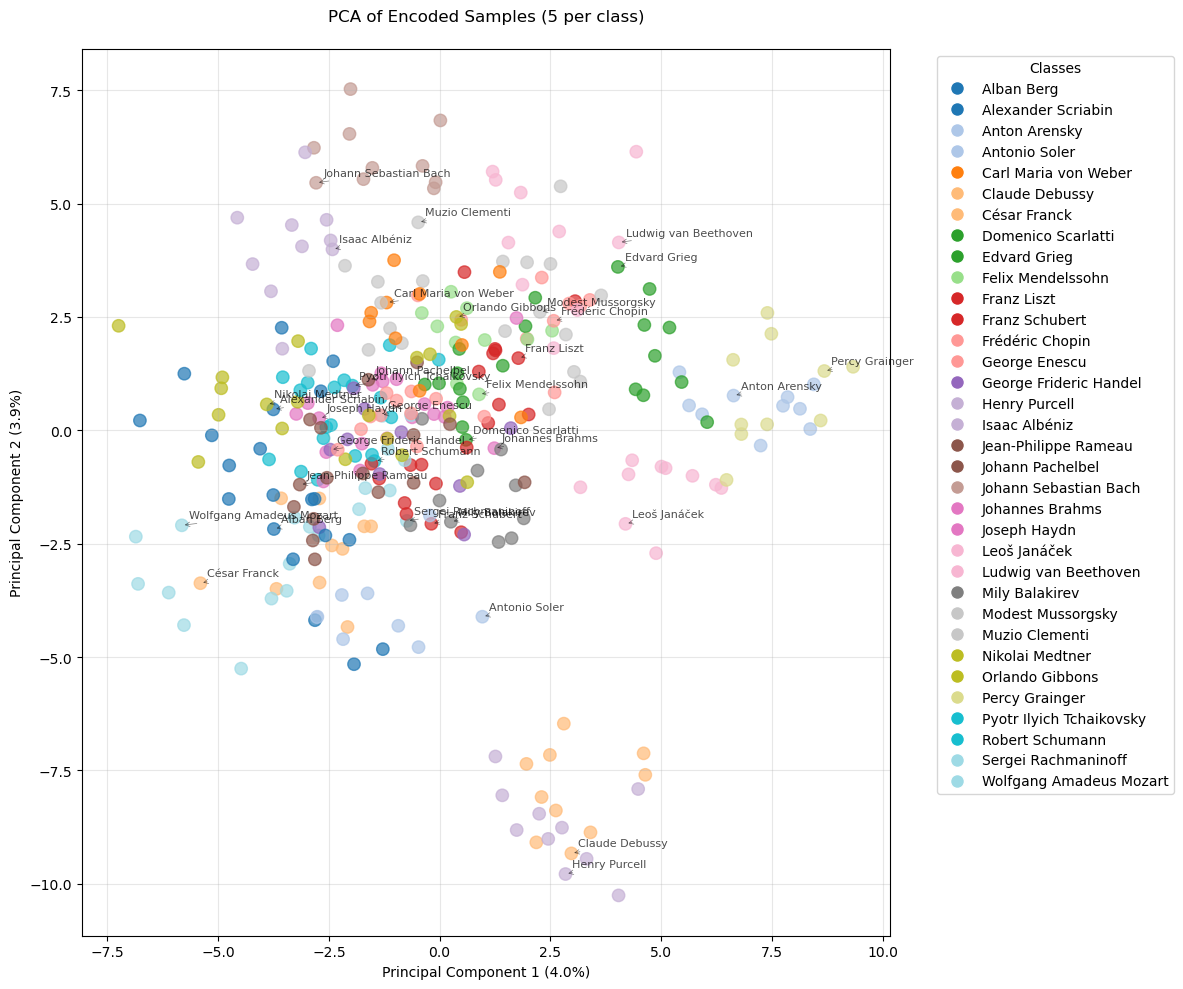

Explained variance ratio: [0.04017478 0.03871914]
Total explained variance: 7.89%
Silhouette Score: 0.208


In [19]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# LATENT SPACE VISUALIZATION AND SILHOUETTE SCORE CALCULATION
# FINDS 10 SONGS OF EACH CLASS AND FEEDS THROUGH ENCODER TO OBTAIN LATENT DISTRIBUTION

# Explicitly set device to CPU
device = torch.device('cuda')

# Initialize model on CPU
model.eval()  # Set to evaluation mode

# Get one sample per class
five_per_class = data.groupby('label').head(10).reset_index()

encodings = []
class_labels  = []
for _, row in five_per_class.iterrows():
    try:
        # Convert label to LONG (int64) - no need for .to(device) when creating on CPU
        label = torch.tensor([row['label']], dtype=torch.long).to(device)
        
        # Convert sequence - ensure float32
        seq = torch.tensor(row['sequence_vector'], dtype=torch.long)
        trim_seq = seq[1:-1].unsqueeze(0).to(device)

        # Forward pass
        with torch.no_grad():
            z, mu, logvar = model.encoder(trim_seq, label)
        
        encodings.append(z.squeeze(0).cpu().numpy())
        class_labels.append(row['label'])
    except Exception as e:
        print(f"Error processing label {row['label']}: {str(e)}")
        continue

X = np.array(encodings)
y = np.array(class_labels)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create the plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab20', alpha=0.7, s=80)

# Create legend with actual class names
unique_labels = sorted(np.unique(y))
legend_elements = []
for label in unique_labels:
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                  label=inv_map[label],
                                  markerfacecolor=plt.cm.tab20(label/max(unique_labels)), 
                                  markersize=10))

plt.legend(handles=legend_elements, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
plt.title('PCA of Encoded Samples (5 per class)', pad=20)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.grid(True, alpha=0.3)

# Optionally, highlight some points with their labels
plotted_labels = set()  # Track which labels we've already plotted

for i, (x, y_pos) in enumerate(X_pca):
    current_label = y[i]  # Get the class label for this point
    
    # Only annotate if we haven't plotted this label yet
    if current_label not in plotted_labels:
        plt.annotate(
            inv_map[current_label],  # Use your label-to-name dictionary
            (x, y_pos),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left',
            fontsize=8,
            alpha=0.7,
            arrowprops=dict(arrowstyle='->', lw=0.5, alpha=0.5)  # Optional arrow
        )
        plotted_labels.add(current_label)  # Mark this label as plotted

plt.tight_layout()
plt.show()

# Print variance information
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

z_vectors = np.array(encodings)  # shape (n_samples, latent_dim)
labels = np.array(class_labels)    # shape (n_samples,)

# Now compute Silhouette Score
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(z_vectors, labels)
print(f"Silhouette Score: {silhouette:.3f}")

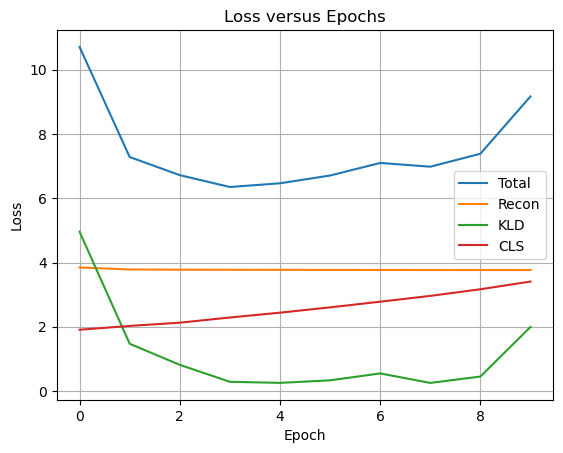

In [20]:
# print loss array anatomy
  def get_exp_weight(epoch_list, total_epochs, start_value, end_value):
       return [
        start_value * (end_value / start_value) ** (epoch / total_epochs)
        for epoch in epoch_list
    ]
epochs_list = list(range(epochs))
kld_weights_list = get_exp_weight(epochs_list,epochs,0.01,0.5)
cls_weights_list = get_exp_weight(epochs_list,epochs,0.5,1.0)
[row[0] for row in loss_array]
loss_array_np = np.array(loss_array)
kld_weighted = np.array(kld_weights_list) * loss_array_np[:, 2]
cls_weighted = np.array(cls_weights_list) * loss_array_np[:, 3]

plt.plot(range(epochs), loss_array_np[:, 0], label="Total")
plt.plot(range(epochs), loss_array_np[:, 1], label="Recon")
plt.plot(range(epochs), kld_weighted, label="KLD")
plt.plot(range(epochs), cls_weighted, label="CLS")
plt.title('Loss versus Epochs')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

/scratch/4872954.1.ece/ipykernel_3685085/4229580278.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier_eval.load_state_dict(torch.load("midi_gru_classifier_v5.pt

Accuracy on mapped classes: 8.33%
Class 5 (GRU class 0): 0.00%
Class 10 (GRU class 1): 0.00%
Class 11 (GRU class 2): 0.00%
Class 12 (GRU class 3): 100.00%
Class 14 (GRU class 4): 0.00%
Class 19 (GRU class 5): 0.00%
Class 20 (GRU class 6): 0.00%
Class 21 (GRU class 7): 0.00%
Class 23 (GRU class 8): 0.00%
Class 30 (GRU class 9): 0.00%
Class 31 (GRU class 10): 0.00%
Class 33 (GRU class 11): 0.00%


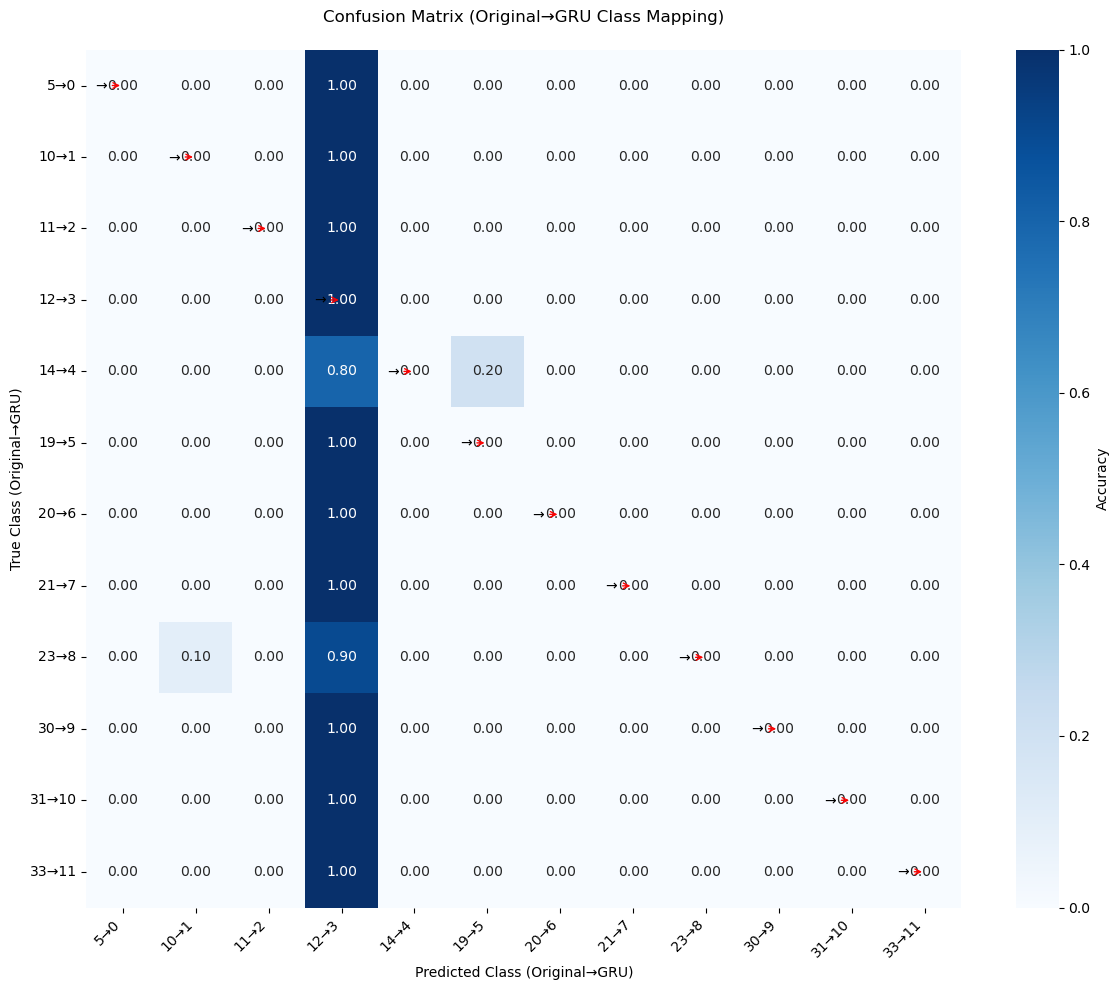

In [73]:
import torch
import numpy as np
from tqdm import tqdm
# CALCULATE TOP-1 ACCURACY FOR GENERATED SONGS AND PRINT FOR EACH CLASS AND CONFUSION MATRIX
# Load models
classifier_eval = MidiGRUClassifier(vocab_size=131, embed_dim=128, hidden_size=128, 
                             num_layers=2, num_classes=12, bidirectional=True, dropout=0.5).to('cuda')
classifier_eval.load_state_dict(torch.load("midi_gru_classifier_v5.pth", map_location=device))
classifier_eval.eval()


model.eval()

# Label mapping (full 34 classes -> GRU's 12 classes)
labels_to_miniGRU_map = {
    5:0, 10:1, 11:2, 12:3, 14:4, 19:5, 
    20:6, 21:7, 23:8, 30:9, 31:10, 33:11
}

# Inverse mapping for evaluation
GRU_to_full_map = {v:k for k,v in labels_to_miniGRU_map.items()}
n_full_classes = 34
n_gru_classes = 12

# Evaluation parameters
n_samples_per_class = 10
results = torch.zeros(n_full_classes, n_full_classes)  # Full label space confusion matrix

# Main evaluation loop
for true_label in tqdm(range(n_full_classes)):
    # Skip labels not in the GRU's vocabulary
    if true_label not in labels_to_miniGRU_map:
        continue
        
    for _ in range(n_samples_per_class):
        # Generate sample
        label = torch.LongTensor([true_label]).to(device)
        mu_c = model.mog_means[label].to(device)  # shape: [latent_dim]
        z = mu_c + torch.randn_like(mu_c).to(device)
        with torch.no_grad():
            generated_seq = model.generate(z, label)
            
            # Classify - get GRU's prediction
            pred_logits = classifier_eval(generated_seq)
            gru_pred_class = pred_logits.argmax(dim=1).item()
            
            # Map back to full label space
            predicted_label = GRU_to_full_map.get(gru_pred_class, -1)
            
            if predicted_label != -1:  # Only count valid mappings
                results[true_label, predicted_label] += 1

# Analysis (only for mapped classes)
valid_classes = list(labels_to_miniGRU_map.keys())
confusion_matrix = results[valid_classes][:, valid_classes] / n_samples_per_class

# Calculate accuracy only on valid classes
accuracy = torch.diag(confusion_matrix).mean().item()
print(f"Accuracy on mapped classes: {accuracy:.2%}")

# Per-class accuracy
for full_label in valid_classes:
    mapped_label = labels_to_miniGRU_map[full_label]
    acc = confusion_matrix[valid_classes.index(full_label), valid_classes.index(full_label)].item()
    print(f"Class {full_label} (GRU class {mapped_label}): {acc:.2%}")
import matplotlib.pyplot as plt
import seaborn as sns

# Filter confusion matrix for only mapped classes
valid_classes = sorted(labels_to_miniGRU_map.keys())
conf_matrix = confusion_matrix.numpy()  # Convert to numpy array

# Create labels showing both original and GRU class IDs
class_labels = [f"{orig}→{gru}" for orig, gru in sorted(labels_to_miniGRU_map.items())]

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={'label': 'Accuracy'}
)

plt.title("Confusion Matrix (Original→GRU Class Mapping)", pad=20)
plt.xlabel("Predicted Class (Original→GRU)")
plt.ylabel("True Class (Original→GRU)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Add arrows showing mapping direction
for i, (orig, gru) in enumerate(sorted(labels_to_miniGRU_map.items())):
    plt.annotate("→", 
                xy=(i+0.5, i+0.5), 
                xytext=(i+0.2, i+0.5),
                arrowprops=dict(arrowstyle="->", color="red"),
                ha='center', va='center')

plt.show()



In [74]:
import torch
import numpy as np
from tqdm import tqdm
# CALCULATE TOP-3 ACCURACY FOR EACH CLASS AND PRINT AVERAGE

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples_per_class = 5
top_k = 3

# Initialize storage - track both original and GRU classes
success_count = torch.zeros(len(labels_to_miniGRU_map))
total_count = torch.zeros(len(labels_to_miniGRU_map))

# Create mapping from GRU class back to original class
gru_to_orig = {v:k for k,v in labels_to_miniGRU_map.items()}

model.eval()

# Evaluation loop
for gru_class in tqdm(range(len(labels_to_miniGRU_map))):
    orig_label = gru_to_orig[gru_class]
    
    for _ in range(n_samples_per_class):
        label_tensor = torch.LongTensor([gru_class]).to(device)
        mu_c = model.mog_means[label].to(device)  # shape: [latent_dim]
        z = mu_c + torch.randn_like(mu_c).to(device)
        with torch.no_grad():
            generated_seq = model.generate(z, label_tensor)
            pred_logits = classifier(generated_seq)
            
            # Get top 3 predictions
            top3_probs, top3_classes = torch.topk(pred_logits, k=top_k, dim=1)
            top3_classes = top3_classes.squeeze().cpu().numpy()
            
            # Check if correct GRU class is in top 3
            if gru_class in top3_classes:
                success_count[gru_class] += 1
            total_count[gru_class] += 1

# Calculate accuracy
top3_accuracy = success_count / total_count
overall_top3_acc = success_count.sum() / total_count.sum()

print(f"\nOverall Top-3 Accuracy: {overall_top3_acc:.2%}")
print("\nPer-Class Top-3 Accuracy:")
for gru_class in range(len(labels_to_miniGRU_map)):
    orig_label = gru_to_orig[gru_class]
    acc = top3_accuracy[gru_class].item()
    print(f"Original Class {orig_label} → GRU Class {gru_class}: {acc:.2%}")

100%|██████████| 12/12 [00:00<00:00, 13.80it/s]


Overall Top-3 Accuracy: 21.67%

Per-Class Top-3 Accuracy:
Original Class 5 → GRU Class 0: 0.00%
Original Class 10 → GRU Class 1: 40.00%
Original Class 11 → GRU Class 2: 0.00%
Original Class 12 → GRU Class 3: 0.00%
Original Class 14 → GRU Class 4: 0.00%
Original Class 19 → GRU Class 5: 0.00%
Original Class 20 → GRU Class 6: 0.00%
Original Class 21 → GRU Class 7: 0.00%
Original Class 23 → GRU Class 8: 0.00%
Original Class 30 → GRU Class 9: 80.00%
Original Class 31 → GRU Class 10: 100.00%
Original Class 33 → GRU Class 11: 40.00%


In [75]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
# EVALUATE OVERALL QUALITY OF THE GENERATIONS BY COMPUTING AVERAGE COSINE SIMILARITY

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples_per_class = 5  # Number of songs to generate per class
n_real_samples = 10     # Number of real examples to compare against per class

# Initialize storage
similarity_results = {}
all_class_labels = range(34)  # Using all 34 classes

model.eval()

for class_label in tqdm(all_class_labels, desc="Evaluating classes"):
    # Get real samples - handle batched data properly
    real_samples = []
    
    # Reset dataloader iterator
    train_data = create_MIDI_Dataloaders(data,num_workers=0)
    data_iter = iter(train_data)
    
    while len(real_samples) < n_real_samples:
        try:
            batch_seq, batch_label = next(data_iter)
            
            # Process batch
            for i in range(batch_label.shape[0]):
                if batch_label[i].item() == class_label:
                    seq_np = batch_seq[i].cpu().numpy()
                    real_samples.append(seq_np)
                    if len(real_samples) >= n_real_samples:
                        break
                        
        except StopIteration:
            break  # No more data
    
    if not real_samples:
        print(f"Skipping class {class_label} - insufficient real samples")
        continue
    
    # Generate synthetic samples
    synthetic_samples = []
    for _ in range(n_samples_per_class):
        label_tensor = torch.LongTensor([class_label]).to(device)
        mu_c = model.mog_means[label_tensor].to(device)  # shape: [latent_dim]
        z = mu_c + torch.randn_like(mu_c).to(device)
        with torch.no_grad():
            generated_seq = model.generate(z, label_tensor)
            gen_np = generated_seq.squeeze(0).cpu().numpy()
            synthetic_samples.append(gen_np)
    
    # Calculate similarities
    real_flat = np.array([seq.flatten() for seq in real_samples])
    synth_flat = np.array([seq.flatten() for seq in synthetic_samples])
    
    similarity_matrix = cosine_similarity(synth_flat, real_flat)
    class_avg_similarity = np.mean(similarity_matrix)
    
    similarity_results[class_label] = {
        'avg_similarity': float(class_avg_similarity),
        'similarity_matrix': similarity_matrix.tolist(),
        'n_real_samples': len(real_samples),
        'n_synthetic_samples': len(synthetic_samples)
    }

# Analysis
print("\nClass Similarity Report:")
for class_label, result in similarity_results.items():
    print(f"Class {class_label}: Avg similarity = {result['avg_similarity']:.3f} "
          f"(based on {result['n_real_samples']} real samples)")

# Overall statistics
all_similarities = [v['avg_similarity'] for v in similarity_results.values() if v['n_real_samples'] > 0]
if all_similarities:
    print(f"\nGlobal average similarity: {np.mean(all_similarities):.3f} ± {np.std(all_similarities):.3f}")
else:
    print("\nNo valid similarity results to aggregate")

Evaluating classes: 100%|██████████| 34/34 [00:07<00:00,  4.68it/s]


Class Similarity Report:
Class 0: Avg similarity = 0.942 (based on 10 real samples)
Class 1: Avg similarity = 0.872 (based on 10 real samples)
Class 2: Avg similarity = 0.833 (based on 10 real samples)
Class 3: Avg similarity = 0.850 (based on 9 real samples)
Class 4: Avg similarity = 0.831 (based on 10 real samples)
Class 5: Avg similarity = 0.855 (based on 10 real samples)
Class 6: Avg similarity = 0.880 (based on 10 real samples)
Class 7: Avg similarity = 0.892 (based on 10 real samples)
Class 8: Avg similarity = 0.898 (based on 10 real samples)
Class 9: Avg similarity = 0.841 (based on 10 real samples)
Class 10: Avg similarity = 0.849 (based on 10 real samples)
Class 11: Avg similarity = 0.863 (based on 10 real samples)
Class 12: Avg similarity = 0.872 (based on 10 real samples)
Class 13: Avg similarity = 0.849 (based on 10 real samples)
Class 14: Avg similarity = 0.874 (based on 10 real samples)
Class 15: Avg similarity = 0.914 (based on 10 real samples)
Class 16: Avg similarity 

In [76]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
# CALCULATE HOW UNIQUE GENERATIONS ARE BASED ON CLASSES USING RELATIVE COSINE SIMILARITY

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples_per_class = 5   # Number of synthetic samples to generate per class
n_real_samples = 10       # Number of real samples per class

# Storage
relative_separation_scores = {}
real_data_by_class = {}
synth_data_by_class = {}

all_class_labels = range(34)  # Assuming 34 classes

model.eval()

# Collect real and synthetic data for all classes
train_data = create_MIDI_Dataloaders(data, num_workers=0)

for class_label in tqdm(all_class_labels, desc="Collecting data"):
    # Collect real samples
    real_samples = []
    data_iter = iter(train_data)
    while len(real_samples) < n_real_samples:
        try:
            batch_seq, batch_label = next(data_iter)
            for i in range(batch_label.shape[0]):
                if batch_label[i].item() == class_label:
                    seq_np = batch_seq[i].cpu().numpy()
                    real_samples.append(seq_np)
                    if len(real_samples) >= n_real_samples:
                        break
        except StopIteration:
            break

    if real_samples:
        real_data_by_class[class_label] = np.array([x.flatten() for x in real_samples])

    # Generate synthetic samples
    synthetic_samples = []
    for _ in range(n_samples_per_class):
        label_tensor = torch.LongTensor([class_label]).to(device)
        mu_c = model.mog_means[label_tensor].to(device)  # shape: [latent_dim]
        z = mu_c + torch.randn_like(mu_c).to(device)
        with torch.no_grad():
            generated_seq = model.generate(z, label_tensor,)
            gen_np = generated_seq.squeeze(0).cpu().numpy()
            synthetic_samples.append(gen_np.flatten())
    if synthetic_samples:
        synth_data_by_class[class_label] = np.array(synthetic_samples)

# Compute relative separation score: intra - inter
for class_label in tqdm(all_class_labels, desc="Evaluating separation"):
    if class_label not in real_data_by_class or class_label not in synth_data_by_class:
        continue

    intra_sim = cosine_similarity(synth_data_by_class[class_label])
    intra_score = np.mean(intra_sim)

    # Inter-class comparison
    other_vectors = []
    for other_label in all_class_labels:
        if other_label != class_label and other_label in real_data_by_class:
            other_vectors.append(real_data_by_class[other_label])
    if not other_vectors:
        continue

    other_vectors = np.vstack(other_vectors)
    inter_sim = cosine_similarity(synth_data_by_class[class_label], other_vectors)
    inter_score = np.mean(inter_sim)

    relative_score = intra_score - inter_score
    relative_separation_scores[class_label] = relative_score

# Report results
print("\nRelative Cosine Separation Scores:")
for class_label, score in relative_separation_scores.items():
    print(f"Class {class_label}: Relative score = {score:.3f}")

if relative_separation_scores:
    all_scores = list(relative_separation_scores.values())
    print(f"\nGlobal avg separation score: {np.mean(all_scores):.3f} ± {np.std(all_scores):.3f}")
else:
    print("No valid results.")


Evaluating separation: 100%|██████████| 34/34 [00:00<00:00, 806.50it/s]


Relative Cosine Separation Scores:
Class 0: Relative score = 0.034
Class 1: Relative score = 0.007
Class 2: Relative score = -0.009
Class 3: Relative score = 0.002
Class 4: Relative score = -0.001
Class 5: Relative score = 0.002
Class 6: Relative score = 0.023
Class 7: Relative score = 0.014
Class 8: Relative score = 0.018
Class 9: Relative score = 0.000
Class 10: Relative score = 0.004
Class 11: Relative score = 0.009
Class 12: Relative score = 0.013
Class 13: Relative score = 0.008
Class 14: Relative score = 0.014
Class 15: Relative score = 0.025
Class 16: Relative score = 0.002
Class 17: Relative score = 0.023
Class 18: Relative score = 0.003
Class 19: Relative score = 0.024
Class 20: Relative score = -0.001
Class 21: Relative score = 0.013
Class 22: Relative score = 0.030
Class 23: Relative score = 0.001
Class 24: Relative score = 0.000
Class 25: Relative score = -0.006
Class 26: Relative score = 0.014
Class 27: Relative score = 0.001
Class 28: Relative score = 0.021
Class 29: Rel

In [77]:
import json
import os
# save model results
def log_model_results(model_name,filename="hyperparam_results_fixed.json"):
    # Load existing results
    if os.path.exists(filename):
        with open(filename, "r") as f:
            results = json.load(f)
    else:
        results = {}

    # Save under new model name
    results[model_name] = {
        "accuracy":float(accuracy),
        "confusion_matrix":conf_matrix.tolist(),
        "top-3 accuracy":float(overall_top3_acc),
        "average cosine similarity":float(np.mean(all_similarities)),
        "average relative cosine similarity": float(np.mean(list(relative_separation_scores.values())))    
    }

    # Write back to file
    with open(filename, "w") as f:
        json.dump(results, f, indent=4)
log_model_results(model_name)